In [1]:
import pandas as pd
import numpy as np
import mysql.connector
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# connection to MySQL database
db = mysql.connector.connect(
    host = 'localhost',
    user = 'root',
    password = '06505',
    database = 'Ecommerce'
)
cursor = db.cursor()

### 1. List all unique cities where customers are located.

In [3]:
query = """ select distinct customer_city from customers"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ['City'])
df

,City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


### 2. Count the number of orders placed in 2017.

In [4]:
query = """Select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""
cursor.execute(query)
data = cursor.fetchall()
"total orders placed in 2017 are ", data[0][0]

('total orders placed in 2017 are ', 90202)

### 3. Find the total sales per category.

In [5]:
query = """select upper(products.product_category) as category, 
Round(sum(payments.payment_value),2) as Sales
from payments join order_items 
on payments.order_id = order_items.order_id
join products
on order_items.product_id = products.product_id
group by Category;"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ['Category','Sales'])
df

,Category,Sales
0,PERFUMERY,4053909.28
1,FURNITURE DECORATION,11441411.13
2,TELEPHONY,3895056.41
3,BED TABLE BATH,13700429.37
4,AUTOMOTIVE,6818354.65
...,...,...
69,CDS MUSIC DVDS,9595.44
70,LA CUISINE,23308.24
71,FASHION CHILDREN'S CLOTHING,6285.36
72,PC GAMER,17395.44


### 4. Calculate the percentage of orders that were paid in installments.

In [6]:
query = """Select (sum(case when payment_installments > 1 then 1 else 0 end)) / count(*) * 100 from payments"""
cursor.execute(query)
data = cursor.fetchall()
"the percentage of orders that were paid in installments is",data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('49.4176'))

### 5. Count the number of customers from each state. 

In [7]:
query = """select customer_state,  count(distinct customer_id) from customers
group by customer_state;"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data,columns = ['State', 'customer_count'])
df

,State,customer_count
0,AC,81
1,AL,413
2,AM,148
3,AP,68
4,BA,3380
5,CE,1336
6,DF,2140
7,ES,2033
8,GO,2020
9,MA,747


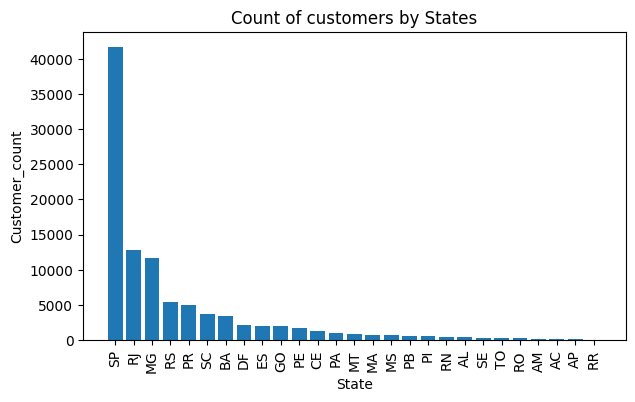

In [8]:
df = df.sort_values(by = "customer_count", ascending = False)
plt.figure(figsize = (7,4))
plt.bar(df["State"],df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("State")
plt.ylabel("Customer_count")
plt.title("Count of customers by States")
plt.show()

### 6. Calculate the number of orders per month in 2018.

In [9]:
query = """select monthName(order_purchase_timestamp) as month, count(order_id) as order_count
from orders where year(order_purchase_timestamp) = 2018
group by month;"""
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data,columns = ['Month','Order_count'])
df

,Month,Order_count
0,July,12584
1,August,13024
2,February,13456
3,June,12334
4,March,14422
5,January,14538
6,May,13746
7,April,13878
8,September,32
9,October,8


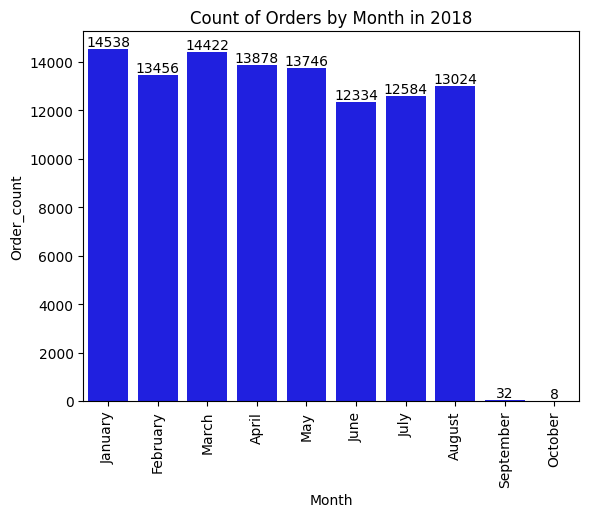

<Figure size 400x200 with 0 Axes>

In [10]:
o = ['January','February','March','April','May','June','July','August','September','October']
ax = sns.barplot(x = df['Month'], y = df['Order_count'], data = df, order = o, color = "blue")
ax.bar_label(ax.containers[0])
plt.xticks(rotation = 90)
plt.title("Count of Orders by Month in 2018")
plt.figure(figsize = (4,2))
plt.show()

In [11]:
query = """
with count_per_order as
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city 
order by average_orders desc; """
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data,columns=['customer city','Average orders'])
df.head(10)

,customer city,Average orders
0,padre carvalho,28.00
1,celso ramos,26.00
2,datas,24.00
3,candido godoi,24.00
4,matias olimpio,20.00
5,cidelandia,16.00
6,curralinho,16.00
7,picarra,16.00
8,morro de sao paulo,16.00
9,teixeira soares,16.00


 ### 7. Find the average number of products per order, grouped by customer city.

In [27]:
query = """with count_per_order as
(select orders.order_id,orders.customer_id,count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city"""

cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ['Cutomer City','Average Orders'])
df


,Cutomer City,Average Orders
0,sao paulo,4.62
1,sao jose dos campos,4.55
2,porto alegre,4.70
3,indaial,4.46
4,treze tilias,5.09
...,...,...
4105,sambaiba,4.00
4106,guairaca,8.00
4107,japaratuba,4.00
4108,tuiuti,4.00


### 8. Calculate the percentage of total revenue contributed by each product category.
# This one

In [12]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""


cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,BED TABLE BATH,42.79
1,HEALTH BEAUTY,41.41
2,COMPUTER ACCESSORIES,39.61
3,FURNITURE DECORATION,35.73
4,WATCHES PRESENT,35.71


### 9. Identify the correlation between product price and the number of times a product has been purchased.

In [13]:
query = """select products.product_category, 
count((order_items.product_id)) as order_count, 
round(avg(order_items.price),2) as price
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category;"""

cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ['Category', 'Order_count','Price'])
arr1 = df["Order_count"]
arr2 = df["Price"]
a = np.corrcoef([arr1,arr2])
print("The correlation between product price and the number of times a product has been purchased is", a[0][1])

The correlation between product price and the number of times a product has been purchased is -0.10631514167157562


### 10. Calculate the total revenue generated by each seller, and rank them by revenue.

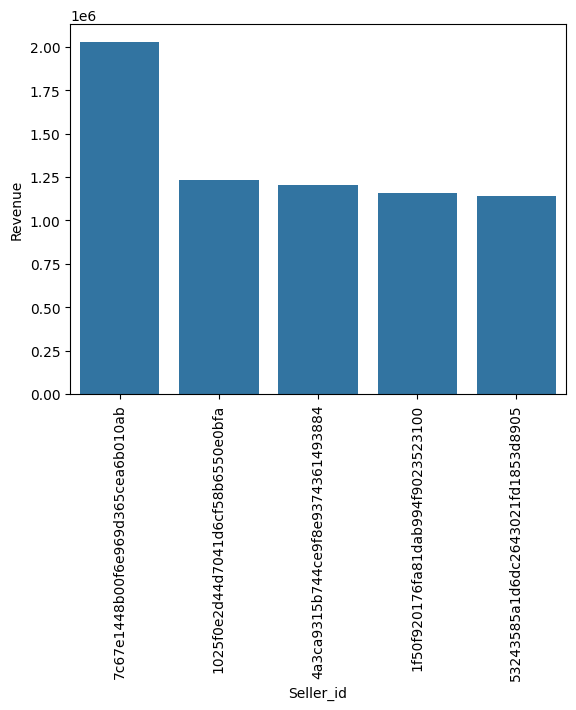

In [14]:
query = """select *, rank() over(order by Revenue desc) as rn from 
(select order_items.seller_id Seller_id, 
sum(payments.payment_value) Revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by Seller_id) a; """

cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ['Seller_id', 'Revenue','Rank'])
df = df.head()
plt.xticks(rotation = 90)
sns.barplot(x = 'Seller_id', y = 'Revenue', data = df)
plt.show()

### 11. Calculate the moving average of order values for each customer over their order history.

In [15]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id,
orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""

cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ['customer_id', 'Order_purchase_timestamp','Payment','Moving_average'])
df

,customer_id,Order_purchase_timestamp,Payment,Moving_average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
...,...,...,...,...
415539,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
415540,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415541,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415542,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


### 12. Calculate the cumulative sales per month for each year.

In [16]:
query = """select years, months,payment,
sum(payment) over(order by years, months) cummulative_sales
from 
(select year(orders.order_purchase_timestamp) years, 
Month(orders.order_purchase_timestamp) months,
round(sum(payments.payment_value),2) payment
from orders join payments
on orders.order_id = payments.order_id
group by years,months order by years, months) as a"""

cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ['Years', 'Months','Payment','Cummulative Sales'])
df

,Years,Months,Payment,Cummulative Sales
0,2016,9,1008.96,1008.96
1,2016,10,236361.92,237370.88
2,2016,12,78.48,237449.36
3,2017,1,553952.16,791401.52
4,2017,2,1167632.04,1959033.56
5,2017,3,1799454.40,3758487.96
6,2017,4,1671152.12,5429640.08
7,2017,5,2371675.28,7801315.36
8,2017,6,2045105.52,9846420.88
9,2017,7,2369531.68,12215952.56


### 13. Calculate the year-over-year growth rate of total sales.

In [17]:
query = """with a as 
(select year(orders.order_purchase_timestamp) years, 
round(sum(payments.payment_value),2) payment
from orders join payments
on orders.order_id = payments.order_id
group by years order by years) 

select years,(payment - lag(payment,1) over(order by years))/(lag(payment,1) over(order by years)) * 100
from a"""

cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ['Year','YOY % Growth'])
df

,Year,YOY % Growth
0,2016,NaN
1,2017,12112.703757
2,2018,20.000924


### 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [18]:
query = """with a as (select customers.customer_id,min(orders.order_purchase_timestamp) as first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on a.customer_id = orders.customer_id 
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < Date_add(orders.order_purchase_timestamp, interval 6 month)
group by a.customer_id)

select 100 * (count(distinct a.customer_id))/(count(distinct b.customer_id)) as Retention_rate
from a left join b
on a.customer_id = b.customer_id;
"""

cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ['Retention Rate'])
df

,Retention Rate
0,None


### Identify the top 3 customers who spent the most money in each year.

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'a9dc96b027d1252bbac0a9b72d837fc6'),
  Text(1, 0, '1d34ed25963d5aae4cf3d7f3a4cda173'),
  Text(2, 0, '4a06381959b6670756de02e07b83815f'),
  Text(3, 0, '1617b1357756262bfa56ab541c47bc16'),
  Text(4, 0, 'c6e2731c5b391845f6800c97401a43a9'),
  Text(5, 0, '3fd6777bbce08a352fddd04e4a7cc8f6'),
  Text(6, 0, 'ec5b2ba62e574342386871631fafd3fc'),
  Text(7, 0, 'f48d464a0baaea338cb25f816991ab1f'),
  Text(8, 0, 'e0a2412720e9ea4f26c1ac985f6a7358')])

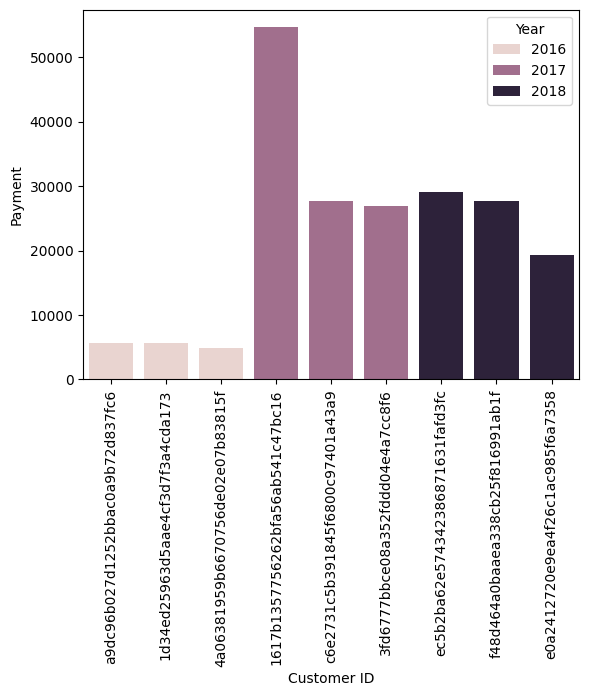

In [24]:
query = """select years,customer_id,payment,d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) as d_rank
from orders join payments
on orders.order_id = payments.order_id
group by years,orders.customer_id) as a
where d_rank <=3
;"""

cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ['Year','Customer ID','Payment','Rank'])
df
sns.barplot(x = 'Customer ID', y = 'Payment', data = df, hue = 'Year')
plt.xticks(rotation = 90)